<a href="https://colab.research.google.com/github/GbemisolaAyejuni/CIND820-Big-Data-Analytics-Project/blob/main/Models_on_Balanced_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic libraries for data processing
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Classifiers
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier

# Evaluation tools
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from yellowbrick.model_selection import feature_importances

#===============================================================================================#

# Classification Models Class

#===============================================================================================#

class Classification():

    """
    This class aims to perform Classifcation using Logistic Regression, Decision Tree, Random Forest.

    Parameters
    ----------
    model_type: 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM'
    the type of classifcation algorithm you would like to apply

    x_train: dataframe
    the independent variables of the training data

    x_val: dataframe
    the independent variables of the validation data

    y_train: series
    the target variable of the training data

    y_val: series
    the target variable of the validation data

    """

    def __init__(self,model_type,x_train,x_val,y_train,y_val):

        self.model_type = model_type
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        self.feature_importances = pd.DataFrame()
        self.name = self

        if self.model_type == 'Logistic Regression':
            self.technique = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
        elif self.model_type == 'Decision Tree':
            self.technique = DecisionTreeClassifier(random_state=42, class_weight='balanced')
        elif self.model_type == 'Random Forest':
            self.technique = RandomForestClassifier(n_estimators=20,n_jobs=-1,random_state=42, class_weight='balanced')

        elif self.model_type == 'Multinomial Naive Bayes':
            self.technique = MultinomialNB()

            # Compute sample weights for handling class imbalance
            sample_weights = compute_sample_weight(class_weight='balanced', y=self.y_train)



#===============================================================================================#

# Score Function

#===============================================================================================#

    def scores(self,model,x_train,x_val,y_train,y_val):

        """
        Gets the accuracy for the given data and creates a dataframe containing scores.
        Parameters
        ----------
        model: 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM'
        the type of classifcation applied
        x_train: dataframe
        the independant variables of the training data
        x_val: dataframe
        the independant variables of the validation data
        y_train: series
        the target variable of the training data
        y_val: series
        the target variable of the validation data

        Returns
        ----------
        scores_table: a dataframe with the model used, the train accuracy and validation accuracy
        """

        self.acc_train = self.best_model.score(x_train,y_train)
        self.acc_val = self.best_model.score(x_val,y_val)

        # Compute MCC for validation data
        y_pred_val = self.best_model.predict(x_val)
        self.mcc_val = matthews_corrcoef(y_val, y_pred_val)

        d = {
            'Model Name': [self.model_type],
            'Train Accuracy': [self.acc_train],
            'Validation Accuracy': [self.acc_val],
            'Accuracy Difference':[self.acc_train-self.acc_val],
            'MCC (Validation)': [self.mcc_val],
            }
        self.scores_table = pd.DataFrame(data=d)

        return self.scores_table


#===============================================================================================#

# Get Scores Function

#===============================================================================================#

    def get_scores(self,params,cv_type):

        """
        Performs a gridsearch cross validation with given hyperparameters and data.
        Gets the accuracy for the given data and creates a dataframe containing scores.
        Parameters
        ----------
        param_grid: dictionary
        specified hyperparameters for chosen classification algorithm to be passed through gridsearch cross validation

        cv_type: 'skf'
        the type of cross validation split to be used for gridsearch
        """

        classifier = self.technique
        fit_classifier = classifier.fit(self.x_train,self.y_train)
        opt_model = GridSearchCV(fit_classifier,
                                 params,
                                 cv=cv_type,
                                 scoring='accuracy',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.x_train,self.y_train)
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,self.best_model,self.x_train,self.x_val,self.y_train,self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        if params == {}:
            pass
        else:
            print("The best hyperparameters are: ", self.best_params,'\n')
         # Validate predictions and compute MCC
        self.y_validated = self.best_model.predict(self.x_val)
        # Validate predictions and compute MCC
        self.y_validated = self.best_model.predict(self.x_val)
        print("Predicted values:", self.y_validated)
        print("True values:", self.y_val)

        self.mcc_val = matthews_corrcoef(self.y_val, self.y_validated)
        self.scores_table['MCC (Validation)'] = [self.mcc_val]

        # Print MCC explicitly
        print(f"MCC (Validation): {self.mcc_val}")


        self.classification_report = pd.DataFrame.from_dict(classification_report(self.y_val,self.y_validated,output_dict=True))

        return self.classification_report

#===============================================================================================#

# Feature Importance Function

#===============================================================================================#

    def get_feature_importances(self):

        """
        Create a confusion matrix.
        Returns
        ----------
        feature_importances_bar : a bar chart with feature importance of given model
        """
        if (self.model_type == 'Decision Tree') or (self.model_type == 'Random Forest') or (self.model_type == 'SVM'):
            self.feature_importances_table = pd.DataFrame(self.best_model.feature_importances_,
                                                    index = self.x_train.columns,
                                                    columns=['Importance']).sort_values('Importance',ascending =False)
            plt.figure(figsize=(9,7.5))
            self.feature_importances_bar = sns.barplot(y= self.feature_importances_table.index[:15], x= self.feature_importances_table['Importance'][:15])
            plt.show()
            return self.feature_importances_bar

        else:
            return print('This classification method does not have the attribute feature importance.')

#===============================================================================================#

# Confusion Matrix Function

#===============================================================================================#

    def conf_matrix(self):

        """
        Create a confusion matrix.

        Returns
        ----------
        scores_table: a confusion matrix
        """

        plt.figure(figsize=(9,9))
        ax = sns.heatmap(confusion_matrix(self.y_val, self.y_validated),
                         annot= True,
                         fmt = '.4g',
                         cbar=0,
                         xticklabels=[1,2,3,4,5],
                         yticklabels=[1,2,3,4,5])
        ax.set(xlabel='Predicted', ylabel='True')
        plt.show()



#===============================================================================================#

# Test Score Function

#===============================================================================================#

    def get_test_scores1(self,X_test,y_test):

        """
        Evaluate the model on the test dataset and compute metrics including MCC.

        Parameters
        ----------
        x_test: dataframe
        independant variables of the test data

        y_test: dataframe
        target variable of the test data
        """
        # Store the test data
        self.y_test = y_test
        self.x_test = X_test


        # Predict on test data
        self.y_tested = self.best_model.predict(self.x_test)

        # Compute metrics
        test_accuracy = self.best_model.score(self.x_test, self.y_test)
        test_mcc = matthews_corrcoef(self.y_test, self.y_tested)

         # Generate classification report
        self.test_classification_report = pd.DataFrame.from_dict(
        classification_report(self.y_test, self.y_tested, output_dict=True))

        # Update the scores table
        '''d = {

            'Model Name': [self.model_type],
            'Test Accuracy': [test_accuracy],
            'MCC (Test)': [test_mcc]
        }'''
        #self.scores_table = self.scores_table.append(pd.DataFrame(d), ignore_index=True)
        #display(self.scores_table)
        # Print metrics
        print("Test Set Metrics:")
        print(f"Accuracy: {test_accuracy:.4f}")
        print(f"Matthews Correlation Coefficient (MCC): {test_mcc:.4f}")
        print("Classification Report:")
        print(self.test_classification_report)

        self.test_classification_report = pd.DataFrame.from_dict(classification_report(self.y_test,self.y_tested,output_dict=True)).iloc[0:3,0:5]

        return self.test_classification_report

#===============================================================================================#

# Show Test Confusion Matrix Function

#===============================================================================================#

    def test_conf_matrix2(self):
      """
      Create a confusion matrix for the test data with dynamic labels.

      Returns
      ----------
      A confusion matrix plot.
      """
      # Dynamically get the unique labels from the true test labels
      labels = sorted(set(self.y_test) | set(self.y_tested))

      # Generate the confusion matrix
      conf_matrix = confusion_matrix(self.y_test, self.y_tested, labels=labels)

      # Print the confusion matrix
      print("\nConfusion Matrix:")
      print(conf_matrix)

      # Plot the confusion matrix
      plt.figure(figsize=(8, 6))
      sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
      plt.xlabel("Predicted Sentiment")
      plt.ylabel("True Sentiment")
      plt.title("Confusion Matrix")
      plt.show()




In [2]:
#basic libraries for linear algebra and data processing
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data preparation tools
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

#time and warnings
import time
import warnings

#settings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_context('poster', font_scale=0.5)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#loading the review dataset
review = pd.read_csv('/content/balanced_reviews.zip')
review.head()
review.shape

#filtering out the stars, text, and review_length columns
reviews = review[['cleaned_text', 'stars', 'review_length']].reset_index().drop(columns='index')

#creating labels from stars
reviews['label'] = reviews['stars'].apply(lambda s: 'positive' if s >= 4 else ('negative' if s <= 2 else 'neutral'))

reviews.head()

#Separate label column from data
X = reviews[['cleaned_text', 'stars', 'review_length']]
y = reviews['label']

In [4]:
#Using stratify parameter in train-test-split ensures that the proportion of target classes in the training and test sets remains consistent with the overall dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42, stratify=y)

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [6]:
#variable that contains stopwords
stop_words_list = list(stopwords.words('english'))

#building the vectorizer
vectorizer = TfidfVectorizer(lowercase = True,
                             stop_words = stop_words_list,
                             ngram_range = (1,2),
                             min_df = 0.01)

#vectorizing the training set
X_train_vect = vectorizer.fit_transform(X_train['cleaned_text'])
print('Shape of X_train vectorized: ',X_train_vect.shape)

#vectorizing the test set
X_test_vect = vectorizer.transform(X_test['cleaned_text'])
print('Shape of X_test vectorized: ',X_test_vect.shape)

Shape of X_train vectorized:  (1414822, 940)
Shape of X_test vectorized:  (606353, 940)


In [7]:
#initializing StandardScaler
scaler = StandardScaler(with_mean = False)
#scaling X_train_vect
X_train_scaled = scaler.fit_transform(X_train_vect)
#scaling X_test_vect
X_test_scaled = scaler.fit_transform(X_test_vect)

In [8]:
#splitting the train dataset into a train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train,
                                                  test_size = 0.3, random_state = 42)

#initializing the Stratified K-fold CV
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

# Logistic Regression

In [9]:
#establishing parameters for GridSearch
parameters = {'penalty':['l1','l2'],
              'C':[0.01,0.05,0.5,5]}

#fitting the model
log_reg = Classification('Logistic Regression', X_train, X_val, y_train, y_val)

#getting scores
log_reg.get_scores(parameters, skf)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference,MCC (Validation)
0,Logistic Regression,0.756715,0.756054,0.000661,0.629038


The best hyperparameters are:  {'C': 0.01, 'penalty': 'l2'} 

Predicted values: [2 2 0 ... 0 2 2]
True values: [2 2 0 ... 0 2 2]
MCC (Validation): 0.62903752520419


,0,1,2,accuracy,macro avg,weighted avg
precision,0.852124,0.465828,0.866378,0.756054,0.728110,0.780680
recall,0.777710,0.612122,0.806230,0.756054,0.732021,0.756054
f1-score,0.813218,0.529048,0.835223,0.756054,0.725830,0.765272
support,169796.000000,84769.000000,169882.000000,0.756054,424447.000000,424447.000000


In [10]:
#display metrics results from running model on test dataset
log_reg.get_test_scores1(X_test_scaled, y_test)

Test Set Metrics:
Accuracy: 0.7546
Matthews Correlation Coefficient (MCC): 0.6268
Classification Report:
                       0              1              2  accuracy  \
precision       0.850449       0.464533       0.865007   0.75458   
recall          0.777481       0.609577       0.804182   0.75458   
f1-score        0.812330       0.527262       0.833486   0.75458   
support    242541.000000  121271.000000  242541.000000   0.75458   

               macro avg   weighted avg  
precision       0.726663       0.779089  
recall          0.730413       0.754580  
f1-score        0.724359       0.763779  
support    606353.000000  606353.000000  


,0,1,2,accuracy,macro avg
precision,0.850449,0.464533,0.865007,0.75458,0.726663
recall,0.777481,0.609577,0.804182,0.75458,0.730413
f1-score,0.812330,0.527262,0.833486,0.75458,0.724359



Confusion Matrix:
[[188571  45792   8178]
 [ 25086  73924  22261]
 [  8074  39420 195047]]


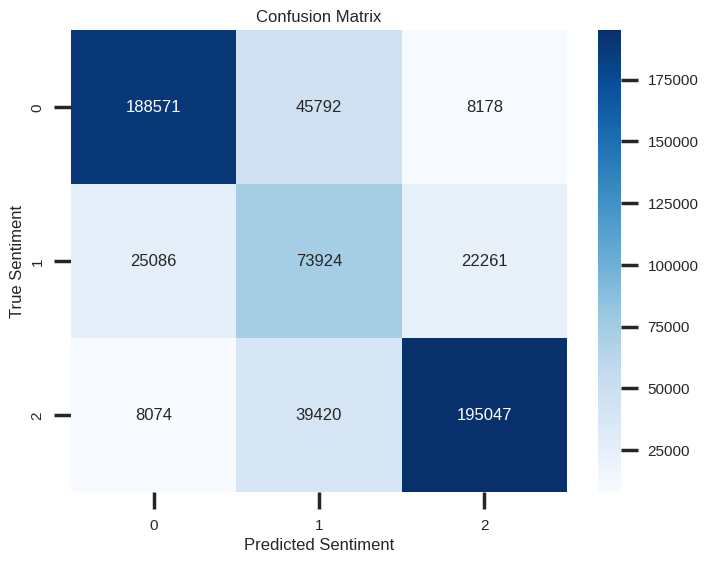

In [11]:
#display confusion matrix
log_reg.test_conf_matrix2()

# Multinomial Naive Bayes

In [12]:
#Multinomial Naive Bayes

#establishing parameters for GridSearch
parameters = {'alpha': [0.001, 0.01, 0.5, 1.0]}
#fitting the model
mnb = Classification('Multinomial Naive Bayes', X_train, X_val, y_train, y_val)
#getting scores
mnb.get_scores(parameters, skf)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference,MCC (Validation)
0,Multinomial Naive Bayes,0.712524,0.711448,0.001076,0.564875


The best hyperparameters are:  {'alpha': 1.0} 

Predicted values: [2 0 0 ... 0 2 2]
True values: [2 2 0 ... 0 2 2]
MCC (Validation): 0.5648747838682471


,0,1,2,accuracy,macro avg,weighted avg
precision,0.810660,0.414397,0.845215,0.711448,0.690090,0.745350
recall,0.718315,0.585261,0.767550,0.711448,0.690375,0.711448
f1-score,0.761699,0.485227,0.804513,0.711448,0.683813,0.723619
support,169796.000000,84769.000000,169882.000000,0.711448,424447.000000,424447.000000


In [13]:
#display metrics results from running model on test dataset
mnb.get_test_scores1(X_test_scaled, y_test)

Test Set Metrics:
Accuracy: 0.7104
Matthews Correlation Coefficient (MCC): 0.5633
Classification Report:
                       0              1              2  accuracy  \
precision       0.809586       0.414139       0.843698  0.710439   
recall          0.718093       0.584031       0.765990  0.710439   
f1-score        0.761100       0.484627       0.802968  0.710439   
support    242541.000000  121271.000000  242541.000000  0.710439   

               macro avg   weighted avg  
precision       0.689141       0.744141  
recall          0.689371       0.710439  
f1-score        0.682898       0.722552  
support    606353.000000  606353.000000  


,0,1,2,accuracy,macro avg
precision,0.809586,0.414139,0.843698,0.710439,0.689141
recall,0.718093,0.584031,0.765990,0.710439,0.689371
f1-score,0.761100,0.484627,0.802968,0.710439,0.682898



Confusion Matrix:
[[174167  57849  10525]
 [ 26552  70826  23893]
 [ 14412  42345 185784]]


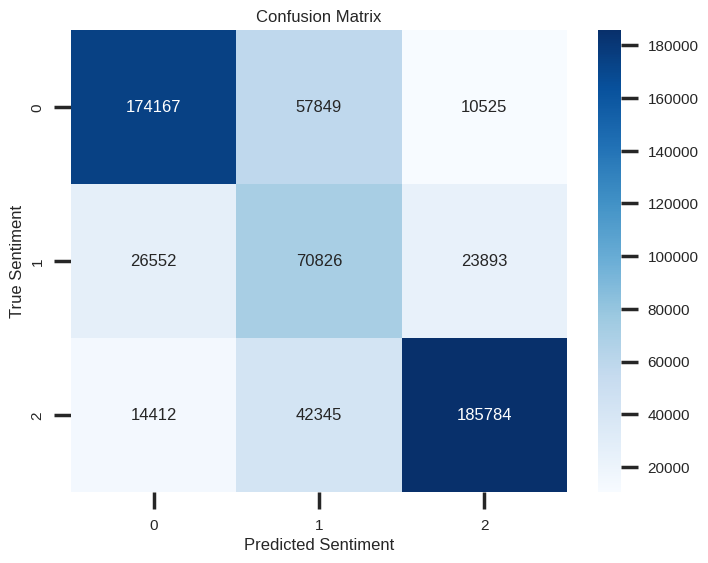

In [14]:

#display confusion matrix
mnb.test_conf_matrix2()

# Decision Tree

In [15]:
#establishing parameters for GridSearch
parameters = {'min_samples_leaf':[3,15,50,100],
              'max_depth':[3,5,7,10]}

#fitting the model
tree = Classification('Decision Tree', X_train, X_val, y_train, y_val)
#getting scores
tree.get_scores(parameters, skf)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference,MCC (Validation)
0,Decision Tree,0.596846,0.591808,0.005038,0.377757


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 3} 

Predicted values: [2 2 2 ... 0 0 2]
True values: [2 2 0 ... 0 2 2]
MCC (Validation): 0.3777574375107083


,0,1,2,accuracy,macro avg,weighted avg
precision,0.689781,0.320820,0.693254,0.591808,0.567951,0.617483
recall,0.630262,0.432080,0.633075,0.591808,0.565139,0.591808
f1-score,0.658680,0.368229,0.661799,0.591808,0.562903,0.601920
support,169796.000000,84769.000000,169882.000000,0.591808,424447.000000,424447.000000


In [16]:
#display metrics results from running model on test dataset
tree.get_test_scores1(X_test_scaled, y_test)

Test Set Metrics:
Accuracy: 0.5917
Matthews Correlation Coefficient (MCC): 0.3781
Classification Report:
                       0              1              2  accuracy  \
precision       0.690396       0.322242       0.693255   0.59172   
recall          0.628339       0.436419       0.632751   0.59172   
f1-score        0.657907       0.370739       0.661623   0.59172   
support    242541.000000  121271.000000  242541.000000   0.59172   

               macro avg   weighted avg  
precision       0.568631       0.617909  
recall          0.565836       0.591720  
f1-score        0.563423       0.601960  
support    606353.000000  606353.000000  


,0,1,2,accuracy,macro avg
precision,0.690396,0.322242,0.693255,0.59172,0.568631
recall,0.628339,0.436419,0.632751,0.59172,0.565836
f1-score,0.657907,0.370739,0.661623,0.59172,0.563423



Confusion Matrix:
[[152398  55884  34259]
 [ 34700  52925  33646]
 [ 33642  55431 153468]]


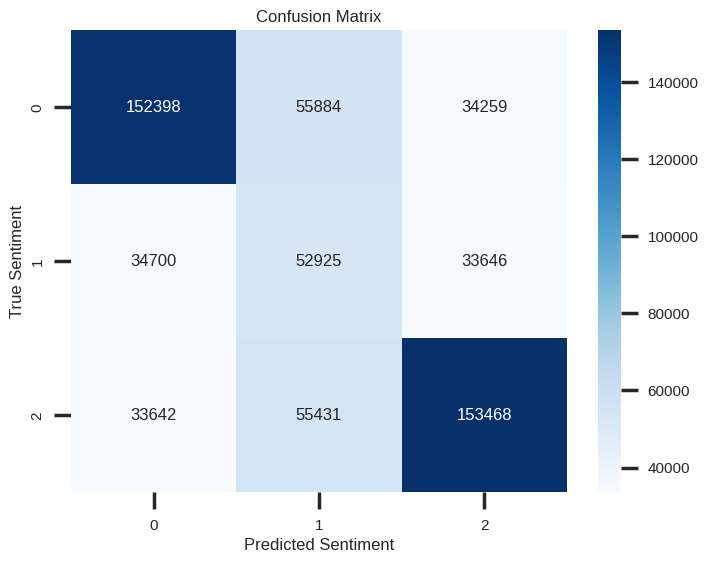

In [17]:
#display confusion matrix
tree.test_conf_matrix2()

# Random Forest

In [18]:
#establishing parameters for GridSearch
parameters = {'min_samples_leaf':[1,3,15,50],
          'max_depth':[5,10,15,20]}
#fitting the model
rf = Classification('Random Forest', X_train, X_val, y_train, y_val)
#getting scores
rf.get_scores(parameters, skf)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference,MCC (Validation)
0,Random Forest,0.722053,0.690256,0.031797,0.525738


The best hyperparameters are:  {'max_depth': 20, 'min_samples_leaf': 3} 

Predicted values: [2 2 2 ... 0 2 2]
True values: [2 2 0 ... 0 2 2]
MCC (Validation): 0.5257381792145353


,0,1,2,accuracy,macro avg,weighted avg
precision,0.781062,0.402663,0.794673,0.690256,0.659466,0.710937
recall,0.728457,0.510918,0.741562,0.690256,0.660312,0.690256
f1-score,0.753843,0.450376,0.767200,0.690256,0.657140,0.698582
support,169796.000000,84769.000000,169882.000000,0.690256,424447.000000,424447.000000


In [19]:
#display metrics results from running model on test dataset
rf.get_test_scores1(X_test_scaled, y_test)

Test Set Metrics:
Accuracy: 0.6889
Matthews Correlation Coefficient (MCC): 0.5234
Classification Report:
                       0              1              2  accuracy  \
precision       0.780248       0.402580       0.790791  0.688901   
recall          0.727461       0.507920       0.740831  0.688901   
f1-score        0.752930       0.449157       0.764997  0.688901   
support    242541.000000  121271.000000  242541.000000  0.688901   

               macro avg   weighted avg  
precision       0.657873       0.708931  
recall          0.658737       0.688901  
f1-score        0.655694       0.697002  
support    606353.000000  606353.000000  


,0,1,2,accuracy,macro avg
precision,0.780248,0.402580,0.790791,0.688901,0.657873
recall,0.727461,0.507920,0.740831,0.688901,0.658737
f1-score,0.752930,0.449157,0.764997,0.688901,0.655694



Confusion Matrix:
[[176439  47815  18287]
 [ 30426  61596  29249]
 [ 19267  43592 179682]]


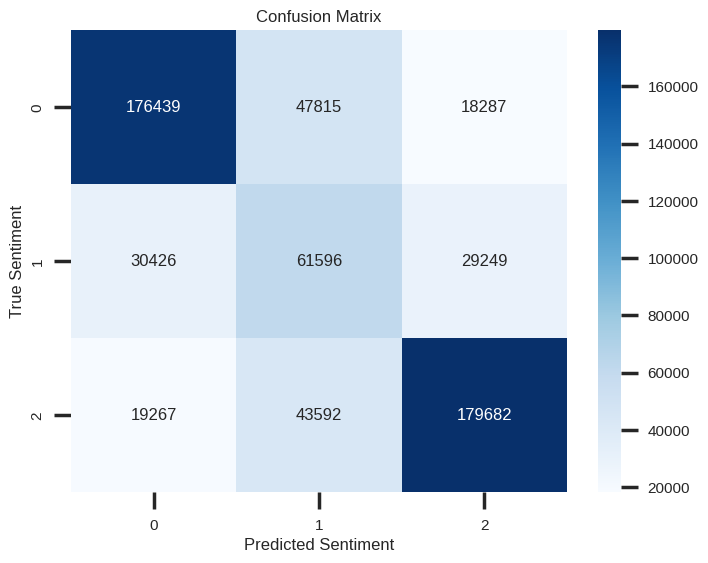

In [20]:
#display confusion matrix
rf.test_conf_matrix2()